<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session_8_Assignment_QnA/backup/S8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# GPU Check

In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



# Ablumentations library


In [4]:
# Import dependencies
!!pip install --upgrade albumentations
!pip install torchscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
import random
import matplotlib.pyplot as plt

In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
batchsize = 512

In [8]:
def data_param ():
    cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    data = cifar_trainset.data / 255 # data is numpy array
    mean = data.mean(axis = (0,1,2))
    std = data.std(axis = (0,1,2))
    return mean, std

### implement (RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8))



In [9]:
def train_transform_func(mean, std):
    train_transform = A.Compose(
      [
      #RandomCrop 32, 32 (after padding of 4) 
      #FlipLR -pytorch library similar present as horizontal flip
      #CutOut(8x8)
      # Pad 4
      A.PadIfNeeded(min_height=32+4, min_width=32+4),
      A.RandomCrop(height = 32, width = 32, always_apply=False, p=1.0),
      A.HorizontalFlip(p = 0.1), 
      A.Cutout(num_holes=1, max_h_size=8, max_w_size=8,  fill_value=tuple(mean)),
      A.Normalize(mean=mean, std=std),
      ToTensorV2(),
      ]
    )
    return lambda img:train_transform(image=np.array(img))["image"]

In [10]:
def test_transform_func(mean, std):
    test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std)
                                        ])
    return test_transform

In [11]:
mean, std = data_param()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform_func(mean, std))
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform_func(mean, std))

Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [12]:
def split_data_set(trainset, testset, cuda = torch.cuda.is_available(), batch_size=256):
    # dataloader arguments - something you'll fetch these from cmdprmt
    dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=8, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

    # train dataloader
    trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

    # test dataloader
    testloader = torch.utils.data.DataLoader(testset, **dataloader_args)
    return trainloader, testloader

In [13]:
trainloader, testloader = split_data_set(trainset, testset)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let us show some of the training images, for fun.



 ship  bird   cat   dog


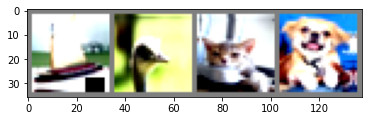

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

:2. Define a Convolution Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [15]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      # PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
      self.prep_layer = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
      ) # 32 | 32

      # Layer1 - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k], R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k], Add(X, R1)
      self.layer1_x  = self.layer_X (64, 128) # 32 | 32 | 16
      self.layer1_res =  self.layer_resnet(128, 128) # 16 | 16

      # Layer 2 - Layer 2 - Conv 3x3 [256k] MaxPooling2D BN ReLU
      self.layer2 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding = 1, bias=False),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(256),
        nn.ReLU()
      ) # 16 | 16 | 8

      # Layer 3 - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k] R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k] Add(X, R2)
      self.layer3_x = self.layer_X(256, 512) # 8 | 8 | 4
      self.layer3_res = self.layer_resnet(512, 512) # 4 | 4

      # MaxPooling with Kernel Size 4
      self.pool = nn.MaxPool2d(4, 4) # 4 | 1

      # FC Layer 
      self.fc = nn.Linear(512, 10,bias=False)
      

    def layer_X(self, in_channels, out_channels):
      layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.MaxPool2d(2, 2), 
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
      )
      return layer

    def layer_resnet(self, in_channels, out_channels):
      res_layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(), 
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
      )
      return res_layer

    def forward(self, x):
      x = self.prep_layer(x)

      x = self.layer1_x(x)
      res1  = self.layer1_res(x)
      x = x + res1
      
      x = self.layer2(x)
      
      x = self.layer3_x(x)
      res2 = self.layer3_res(x)
      x = x + res2
      
      x = self.pool(x)
      #print ("here1:",x.shape)
      
      x = x.view(x.size(0), -1)
      #print ("here2:", x.shape)
      x = self.fc(x)
      return F.softmax(x, dim=-1)#SoftMax

In [16]:
from torchscan import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

cuda
_______________________________________________________________________________
Layer           Type          Output Shape         Param #      Receptive field
net             Net           (-1, 10)             0            1              
├─prep_layer    Sequential    (-1, 64, 32, 32)     1,985        3              
├─layer1_x      Sequential    (-1, 128, 16, 16)    74,241       6              
├─layer1_res    Sequential    (-1, 128, 16, 16)    295,938      14             
├─layer2        Sequential    (-1, 256, 8, 8)      295,937      20             
├─layer3_x      Sequential    (-1, 512, 4, 4)      1,181,697    32             
├─layer3_res    Sequential    (-1, 512, 4, 4)      4,722,690    64             
├─pool          MaxPool2d     (-1, 512, 1, 1)      0            88             
├─fc            Linear        (-1, 10)             5,120        88             
Trainable params: 6,573,120
Non-trainable params: 0
Total params: 6,573,120
---------------------------------------

3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [17]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

Uses One Cycle Policy such that:
Total Epochs = 24
Max at Epoch = 5
LRMIN = FIND
LRMAX = FIND
NO Annihilation



In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [30]:
#training loops
def train(model, device, train_loader, train_acc, train_loss, optimizer, scheduler, l_rate, criterion):

    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):

        ## Get data samples
        data, target = data.to(device), target.to(device)

        ## Init
        optimizer.zero_grad()

        ## Predict
        y_pred = model(data)

        ## Calculate loss
        loss = criterion(y_pred, target)

        #train_loss.append(loss.data.cpu().numpy().item())
        train_loss.append(loss.item())

        ## Backpropagation
        loss.backward()

        optimizer.step()
        scheduler.step()

        # record and update learning rate
        l_rate.append(get_lr(optimizer))


        ## Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}% learning_rate={l_rate[-1]:0.8f}')
        train_acc.append(100*correct/processed)

In [20]:
# test loop
def test(model, device, test_loader, test_acc, test_losses, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [21]:
def start_training_process(model, device, trainloader, testloader, optimizer='Adam', learning_rate = 0.01, epochs = 20):

    # Hyperparameters
    train_acc, train_losses, test_acc, test_losses, l_rate = [], [], [], [], []
    if optimizer == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learning_rate, epochs = epochs, steps_per_epoch = len(trainloader), pct_start = 0.2) # pct_start = 0.2 (~5/24) since max_lr is required at Epoch 5

    for epoch in range(epochs):
        print("EPOCH:", epoch + 1)
        train(model, device, trainloader, train_acc, train_losses, optimizer, scheduler, l_rate, criterion)
        test(model, device, testloader, test_acc, test_losses, criterion)


    return train_acc, train_losses, test_acc, test_losses, l_rate

# Uses One Cycle Policy such that:
Total Epochs = 24
Max at Epoch = 5
LRMIN = FIND
LRMAX = FIND
NO Annihilation

In [22]:
# LR finder https://github.com/davidtvs/pytorch-lr-finder
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-04


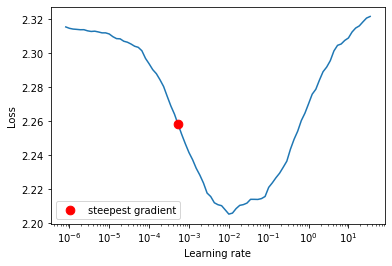

In [23]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [24]:
print ("LR finder:", dir(lr_finder))

LR finder: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_for_scheduler', '_move_to_device', '_set_learning_rate', '_train_batch', '_validate', 'best_loss', 'cache_dir', 'criterion', 'device', 'history', 'memory_cache', 'model', 'model_device', 'optimizer', 'plot', 'range_test', 'reset', 'state_cacher']


LR suggestion: steepest gradient
Suggested LR: 5.34E-04


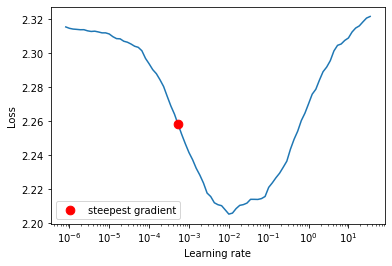

In [25]:
_, lr_suggested = lr_finder.plot()

In [26]:
print (lr_suggested)

0.000533669923120631


In [27]:
num_epochs = 24 # change to 20
learning_rate = float(lr_suggested) #0.025 # change to 0.01
print ("here", learning_rate)
train_acc, train_losses, test_acc, test_losses, l_rate = start_training_process(model, device, trainloader, testloader, optimizer = "Adam", learning_rate = learning_rate, epochs = num_epochs)

here 0.000533669923120631
EPOCH: 1


Loss=2.0661163330078125 Batch_id=195 Accuracy=34.74 learning_rate=0.00007439: 100%|██████████| 196/196 [00:26<00:00,  7.39it/s]



Test set: Average loss: 0.0080, Accuracy: 4640/10000 (46.40%)

EPOCH: 2


Loss=1.9296104907989502 Batch_id=195 Accuracy=49.40 learning_rate=0.00021155: 100%|██████████| 196/196 [00:26<00:00,  7.40it/s]



Test set: Average loss: 0.0078, Accuracy: 5219/10000 (52.19%)

EPOCH: 3


Loss=1.7002112865447998 Batch_id=195 Accuracy=60.60 learning_rate=0.00037603: 100%|██████████| 196/196 [00:24<00:00,  7.99it/s]



Test set: Average loss: 0.0074, Accuracy: 6104/10000 (61.04%)

EPOCH: 4


Loss=1.7724332809448242 Batch_id=195 Accuracy=67.67 learning_rate=0.00049971: 100%|██████████| 196/196 [00:24<00:00,  8.00it/s]



Test set: Average loss: 0.0073, Accuracy: 6188/10000 (61.88%)

EPOCH: 5


Loss=1.6987206935882568 Batch_id=195 Accuracy=74.52 learning_rate=0.00053352: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s]



Test set: Average loss: 0.0068, Accuracy: 7700/10000 (77.00%)

EPOCH: 6


Loss=1.7802966833114624 Batch_id=195 Accuracy=79.54 learning_rate=0.00052850: 100%|██████████| 196/196 [00:24<00:00,  7.99it/s]



Test set: Average loss: 0.0067, Accuracy: 7954/10000 (79.54%)

EPOCH: 7


Loss=1.6360795497894287 Batch_id=195 Accuracy=82.56 learning_rate=0.00051649: 100%|██████████| 196/196 [00:24<00:00,  7.99it/s]



Test set: Average loss: 0.0067, Accuracy: 7880/10000 (78.80%)

EPOCH: 8


Loss=1.6047184467315674 Batch_id=195 Accuracy=84.43 learning_rate=0.00049781: 100%|██████████| 196/196 [00:24<00:00,  7.99it/s]



Test set: Average loss: 0.0067, Accuracy: 7954/10000 (79.54%)

EPOCH: 9


Loss=1.595629334449768 Batch_id=195 Accuracy=86.30 learning_rate=0.00047296: 100%|██████████| 196/196 [00:24<00:00,  8.01it/s]



Test set: Average loss: 0.0065, Accuracy: 8354/10000 (83.54%)

EPOCH: 10


Loss=1.6252975463867188 Batch_id=195 Accuracy=87.77 learning_rate=0.00044260: 100%|██████████| 196/196 [00:24<00:00,  8.02it/s]



Test set: Average loss: 0.0065, Accuracy: 8282/10000 (82.82%)

EPOCH: 11


Loss=1.584740161895752 Batch_id=195 Accuracy=88.85 learning_rate=0.00040755: 100%|██████████| 196/196 [00:24<00:00,  7.99it/s]



Test set: Average loss: 0.0065, Accuracy: 8509/10000 (85.09%)

EPOCH: 12


Loss=1.618199348449707 Batch_id=195 Accuracy=90.01 learning_rate=0.00036874: 100%|██████████| 196/196 [00:24<00:00,  7.94it/s]



Test set: Average loss: 0.0064, Accuracy: 8557/10000 (85.57%)

EPOCH: 13


Loss=1.548991322517395 Batch_id=195 Accuracy=91.10 learning_rate=0.00032721: 100%|██████████| 196/196 [00:24<00:00,  7.95it/s]



Test set: Average loss: 0.0063, Accuracy: 8767/10000 (87.67%)

EPOCH: 14


Loss=1.5598138570785522 Batch_id=195 Accuracy=92.28 learning_rate=0.00028407: 100%|██████████| 196/196 [00:25<00:00,  7.83it/s]



Test set: Average loss: 0.0063, Accuracy: 8813/10000 (88.13%)

EPOCH: 15


Loss=1.547970175743103 Batch_id=195 Accuracy=93.05 learning_rate=0.00024046: 100%|██████████| 196/196 [00:24<00:00,  7.99it/s]



Test set: Average loss: 0.0064, Accuracy: 8762/10000 (87.62%)

EPOCH: 16


Loss=1.5251567363739014 Batch_id=195 Accuracy=93.85 learning_rate=0.00019756: 100%|██████████| 196/196 [00:24<00:00,  7.97it/s]



Test set: Average loss: 0.0063, Accuracy: 8924/10000 (89.24%)

EPOCH: 17


Loss=1.4910144805908203 Batch_id=195 Accuracy=94.75 learning_rate=0.00015651: 100%|██████████| 196/196 [00:24<00:00,  7.97it/s]



Test set: Average loss: 0.0063, Accuracy: 8959/10000 (89.59%)

EPOCH: 18


Loss=1.5180962085723877 Batch_id=195 Accuracy=95.28 learning_rate=0.00011841: 100%|██████████| 196/196 [00:24<00:00,  7.95it/s]



Test set: Average loss: 0.0062, Accuracy: 9022/10000 (90.22%)

EPOCH: 19


Loss=1.484527349472046 Batch_id=195 Accuracy=95.91 learning_rate=0.00008427: 100%|██████████| 196/196 [00:24<00:00,  7.98it/s]



Test set: Average loss: 0.0063, Accuracy: 9028/10000 (90.28%)

EPOCH: 20


Loss=1.5284616947174072 Batch_id=195 Accuracy=96.29 learning_rate=0.00005501: 100%|██████████| 196/196 [00:24<00:00,  7.95it/s]



Test set: Average loss: 0.0062, Accuracy: 9063/10000 (90.63%)

EPOCH: 21


Loss=1.4629077911376953 Batch_id=195 Accuracy=96.35 learning_rate=0.00003140: 100%|██████████| 196/196 [00:24<00:00,  7.96it/s]



Test set: Average loss: 0.0062, Accuracy: 9085/10000 (90.85%)

EPOCH: 22


Loss=1.4794094562530518 Batch_id=195 Accuracy=96.57 learning_rate=0.00001409: 100%|██████████| 196/196 [00:24<00:00,  8.01it/s]



Test set: Average loss: 0.0062, Accuracy: 9097/10000 (90.97%)

EPOCH: 23


Loss=1.4751837253570557 Batch_id=195 Accuracy=96.76 learning_rate=0.00000353: 100%|██████████| 196/196 [00:24<00:00,  8.01it/s]



Test set: Average loss: 0.0062, Accuracy: 9103/10000 (91.03%)

EPOCH: 24


Loss=1.4806313514709473 Batch_id=195 Accuracy=96.78 learning_rate=0.00000000: 100%|██████████| 196/196 [00:24<00:00,  7.97it/s]



Test set: Average loss: 0.0062, Accuracy: 9100/10000 (91.00%)



# Plotting train and test accuracys

Text(0.5, 1.0, 'Test Accuracy')

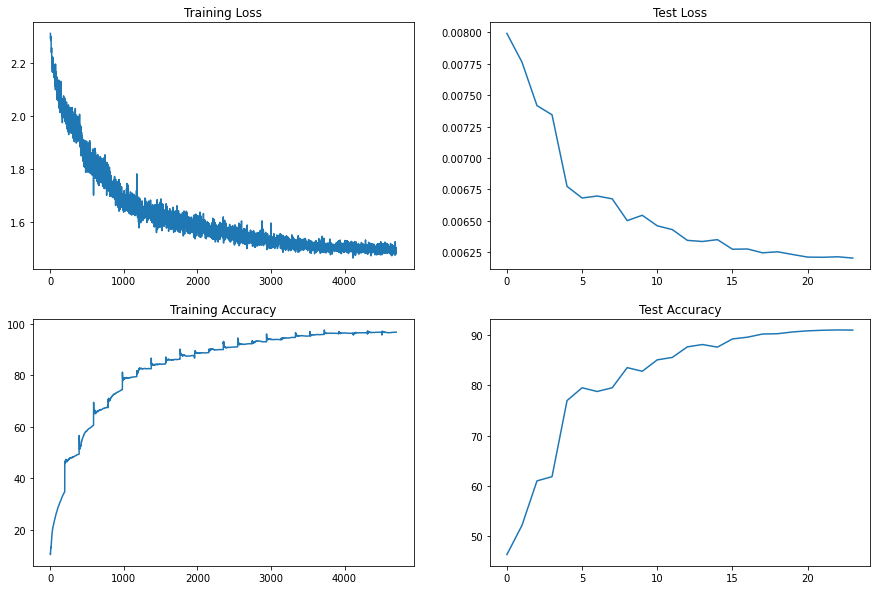

In [28]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Learning rate plot

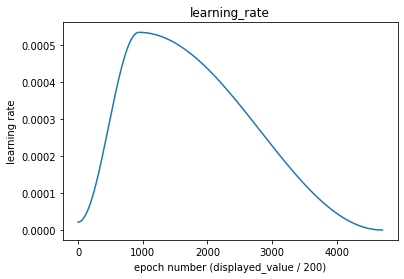

In [29]:
plt.plot(l_rate)
plt.title("learning_rate")
plt.xlabel("epoch number (displayed_value / 200)")
plt.ylabel("learning rate")
plt.show()